In [12]:
#Vizualize demand spatial distribution in Amsterdam emoped pilot

In [13]:
### Imports 
import os
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches

import pandas as pd
import re
import xml.etree.ElementTree as ET
import json

sys.path.append('../../')
from script.conversion.bison.coordinates import rd_to_utm
from mnms.graph.layers import PublicTransportLayer, MultiLayerGraph, OriginDestinationLayer
from mnms.generation.roads import generate_pt_line_road, generate_one_zone
from mnms.generation.layers import generate_bbox_origin_destination_layer
from mnms.vehicles.veh_type import Tram, Metro, Bus
from mnms.generation.zones import generate_one_zone
from mnms.mobility_service.public_transport import PublicTransportMobilityService
from mnms.time import TimeTable, Dt, Time
from mnms.io.graph import load_graph, save_graph, save_odlayer
from mnms.tools.render import draw_roads, draw_line, draw_odlayer
from mnms.tools.geometry import points_in_polygon, get_bounding_box

In [14]:
### Parameters

# Files and directories
current_dir = os.getcwd()
indir = current_dir + '/inputs/'
outdir = current_dir + '/outputs/'

f = open('params.json')
params = json.load(f)

#amsterdam_json_filepath = indir + 'new_network.json' # mlgraph with the road network only
#ams_dmd_path = indir + 'test_all_in_highway_7h_9h.csv' # dmd inside ringroad 7-9am
init_emoped_path = indir + 'init_pos_emoped.csv'
fn_stations = indir + 'emoped_stations.csv'

nb_emoped = 100

np.random.seed(68568)

In [15]:
### Get the MLGraph without TCs 
amsterdam_graph = load_graph(indir+params['fn_network'])
roads = amsterdam_graph.roads

In [16]:
# Load dmd
db_dmd = pd.read_csv(indir+params['fn_demand'], sep=';')

In [17]:
db_dmd

,ID,DEPARTURE,ORIGIN,DESTINATION
0,1013696-1,07:00:11,629891.5501061575 5807764.308142089,629206.7485171846 5802718.428188983
1,1041202-1,07:00:15,626515.7810087365 5804857.124552886,627880.7645051661 5801620.341258972
2,1082035-1,07:02:13,626783.0014626541 5802019.078548846,627521.5991698907 5802139.395577453
3,1036317-2,07:03:09,626733.1728912272 5802692.911896407,626796.1714493468 5803249.104904612
4,1039609-1,07:03:33,626657.4039649597 5802667.380458823,625904.7375438417 5801304.4185826555
...,...,...,...,...
178,1086906-1,08:58:15,628687.7257023167 5801084.169195911,629113.4636707206 5801401.171718666
179,1008430-1,08:58:43,631217.0634915064 5807018.895249622,629472.3143697395 5803759.93006108
180,1060582-1,08:59:00,627953.680650466 5806399.10925086,629771.0274529499 5801512.188125436
181,1040867-1,08:59:07,626595.303046123 5802680.543638766,625192.4512876405 5801536.0953376135


In [18]:
nb_dmd = len(db_dmd)
origins = np.zeros((len(db_dmd),2))
destinations = np.zeros((len(db_dmd),2))
for i, row in db_dmd[:].iterrows():
    origins[i] = [float(o) for o in row['ORIGIN'].split(' ')]
    destinations[i] = [float(d) for d in row['DESTINATION'].split(' ')]

# Free-floating

In [19]:
# Emoped initial locations
x = np.random.random(nb_emoped)*(origins[:,0].max()-origins[:,0].min()) + origins[:,0].min()
y = np.random.random(nb_emoped)*(origins[:,1].max()-origins[:,1].min()) + origins[:,1].min()
df_emoped = pd.DataFrame({'x':x, 'y':y})

In [20]:
nodes_pos = np.array([node.position for node in roads.nodes.values()])
nodes_id = list(roads.nodes.keys())

In [21]:
closest_nodes = []
x_nodes = []
y_nodes = []
for i, row in df_emoped.iterrows():
    x = row['x']
    y = row['y']
    dist_nodes = (x-nodes_pos[:,0])**2 + (y-nodes_pos[:,1])**2
    i_min = np.argmin(dist_nodes)
    closest_nodes.append(nodes_id[i_min])
    x_nodes.append(nodes_pos[i_min,0])
    y_nodes.append(nodes_pos[i_min,1])
df_emoped['closest_node'] = closest_nodes
df_emoped['x_node'] = x_nodes
df_emoped['y_node'] = y_nodes

In [22]:
df_emoped

,x,y,closest_node,x_node,y_node
0,629171.281563,5.808831e+06,m46547838,629150.444572,5.808778e+06
1,628541.664731,5.806663e+06,m267046127,628622.124402,5.806374e+06
2,625125.507641,5.800911e+06,m46273905,625134.218841,5.801073e+06
3,629496.982467,5.802903e+06,m3844847569,629432.226056,5.802923e+06
4,628376.885146,5.805566e+06,m46449205,628390.214308,5.805547e+06
...,...,...,...,...,...
95,627824.417805,5.805073e+06,TRAM_3_DIR1_3,627895.579645,5.805059e+06
96,629248.305138,5.803172e+06,m2021901253,629256.647541,5.803178e+06
97,628528.275883,5.807226e+06,m46504515,628703.264006,5.807202e+06
98,631824.174213,5.805593e+06,m46450187,631832.561429,5.805658e+06


In [23]:
#df_emoped.to_csv(init_emoped_path)

In [24]:
a=df_emoped.value_counts('closest_node')

In [41]:
#for node, nb in a.items():
#    print(node,nb)

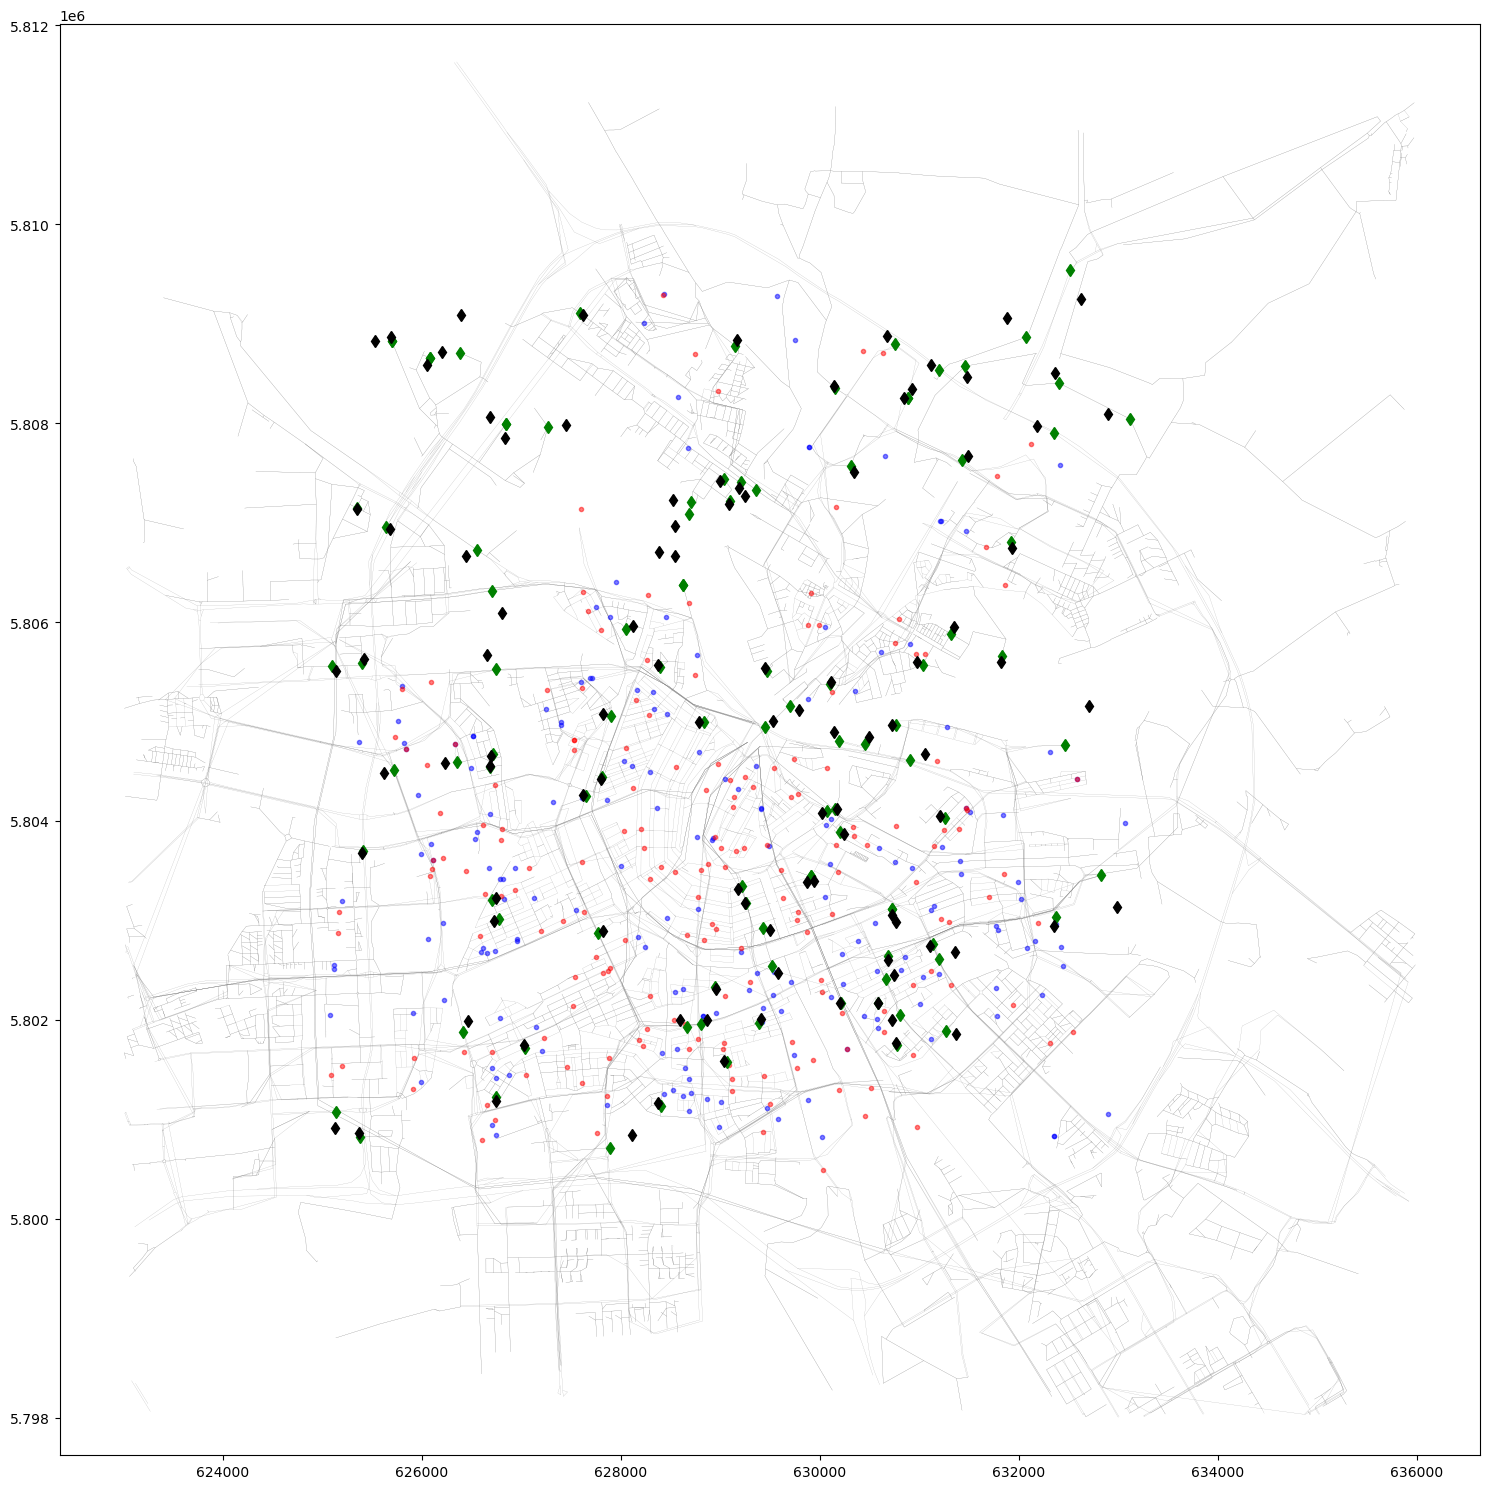

In [26]:
fig, ax = plt.subplots(figsize=(15, 15))
draw_roads(ax, roads, color='grey', linkwidth=0.1, nodesize=0, draw_stops=False, node_label=False)

plt.plot(origins[:,0], origins[:,1], 'b.', alpha=0.5)
plt.plot(destinations[:,0], destinations[:,1], 'r.', alpha=0.5)
#plt.plot(od_clustered[:,0], od_clustered[:,1], 'gd', alpha=0.5)

plt.plot(df_emoped['x_node'], df_emoped['y_node'],'gd')
plt.plot(df_emoped['x'], df_emoped['y'],'kd')
    
#plt.xlim([624e3, 635e3])
#plt.ylim([5.795e6, 5.8125e6])

# Station locations

In [27]:
# use origin for stations locations

In [29]:
f = open(indir+params['fn_odlayer'])
od_layer = json.load(f)

nodes_pos = np.array([node.position for node in roads.nodes.values()])
nodes_id = list(roads.nodes.keys())

In [36]:
for i in od_layer['ORIGINS'].items():
    print(i[1])

[625213.8940527465, 5801993.660678541, 625213.8940527465, 5801993.660678541]
[631754.161805058, 5801424.988529366, 631754.161805058, 5801424.988529366]
[630532.6834129603, 5807104.353634378, 630532.6834129603, 5807104.353634378]
[634180.8859199167, 5801628.67127334, 634180.8859199167, 5801628.67127334]
[626632.0412073835, 5804149.311034766, 626632.0412073835, 5804149.311034766]
[627877.8406526597, 5801324.969205299, 627877.8406526597, 5801324.969205299]
[630247.2837475027, 5803926.799279504, 630247.2837475027, 5803926.799279504]
[628916.8764900903, 5804720.950140387, 628916.8764900903, 5804720.950140387]
[628474.5433502287, 5808588.781165832, 628474.5433502287, 5808588.781165832]
[633193.5340303438, 5806539.780518779, 633193.5340303438, 5806539.780518779]
[633278.1041687792, 5799872.62712063, 633278.1041687792, 5799872.62712063]
[629563.5094549129, 5802037.633854617, 629563.5094549129, 5802037.633854617]
[631999.8146581551, 5803277.756683535, 631999.8146581551, 5803277.756683535]
[6253

In [39]:
closest_nodes = []
x_nodes = []
y_nodes = []
for i in od_layer['ORIGINS'].items():
    x = i[1][0]
    y = i[1][1]
    dist_nodes = (x-nodes_pos[:,0])**2 + (y-nodes_pos[:,1])**2
    i_min = np.argmin(dist_nodes)
    closest_nodes.append(nodes_id[i_min])
    x_nodes.append(nodes_pos[i_min,0])
    y_nodes.append(nodes_pos[i_min,1])

# random number of emoped per station
emoped_st = np.random.choice()
df_st_emoped = pd.DataFrame({'closest_node': closest_nodes, 'x_node':x_nodes, 'y_node':y_nodes})

In [42]:
df_st_emoped.to_csv(fn_stations)

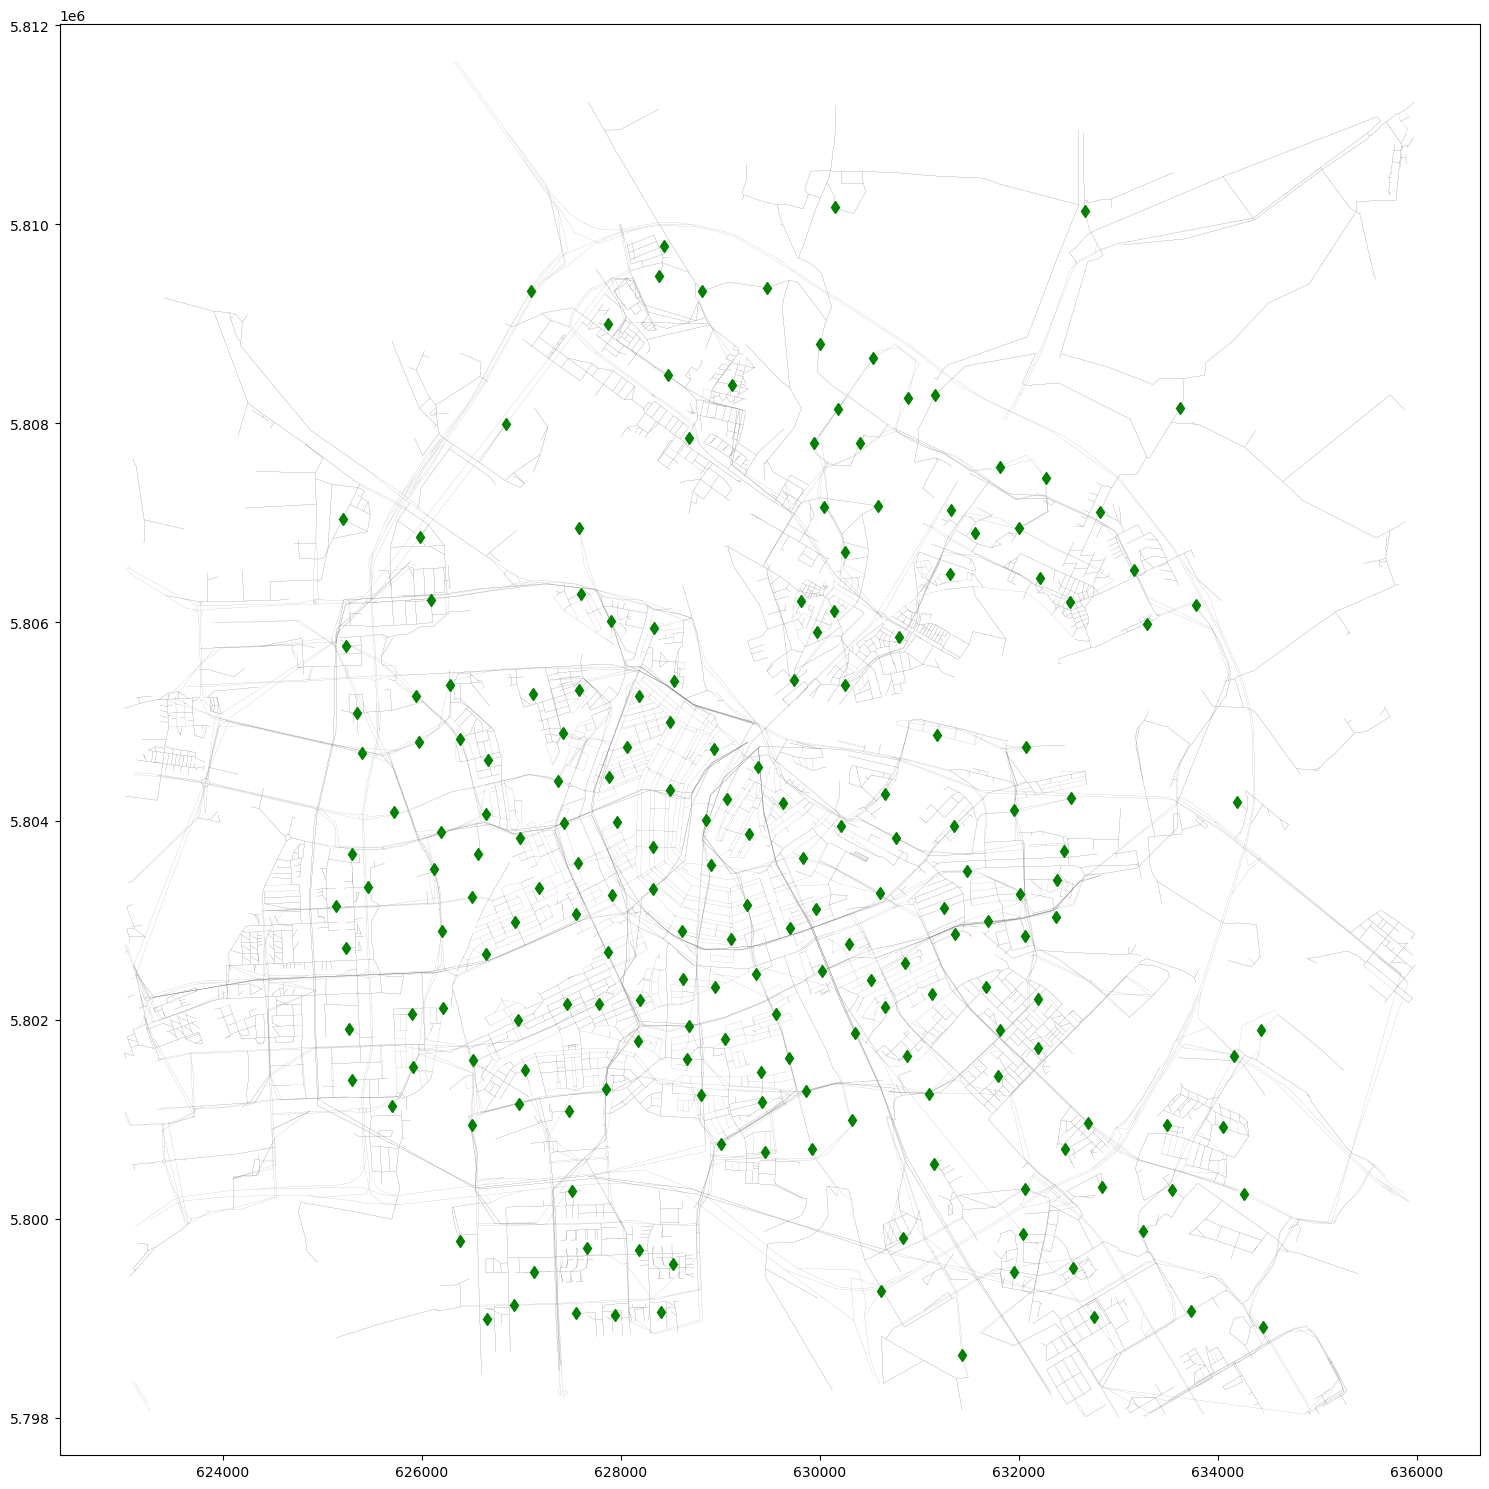

In [45]:
fig, ax = plt.subplots(figsize=(15, 15))
draw_roads(ax, roads, color='grey', linkwidth=0.1, nodesize=0, draw_stops=False, node_label=False)

plt.plot(df_st_emoped['x_node'], df_st_emoped['y_node'],'gd')